In [2]:
import xarray as xr 
import cartopy
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cv2
from matplotlib.patches import Polygon

In [3]:
# 读取nc数据
initData = xr.open_dataset(r"C:\Users\2892706668\Desktop\GRIDSAT-B1.2023.07.23.03.v02r01.nc")
initData_t2 = xr.open_dataset(r"C:\Users\2892706668\Desktop\GRIDSAT-B1.2023.07.23.06.v02r01.nc")
initData_t3 = xr.open_dataset(r"C:\Users\2892706668\Desktop\GRIDSAT-B1.2023.07.23.09.v02r01.nc")


In [4]:
# 纬度范围:[-60， 60]
initData = initData.sel(lat = slice(-60, 60)   )        
initData_t2 = initData_t2.sel(lat = slice(-60, 60)   )  
initData_t3 = initData_t3.sel(lat = slice(-60, 60)   )

In [5]:
print(initData.irwin_cdr.shape)


(1, 1715, 5143)


# 椭圆拟合

# 连续区域识别

## 找出需要的亮温区

In [6]:
tb = initData.irwin_cdr[0].to_numpy()
tb2 = initData_t2.irwin_cdr[0].to_numpy()
tb3 = initData_t3.irwin_cdr[0].to_numpy()
all_t_tbdata = [tb, tb2, tb3]                

print(tb)
# 取出tb的非nan的值
print(tb[~np.isnan(tb)].max())
print(tb[~np.isnan(tb)].min())

[[254.75    261.8     261.8     ... 265.47998 265.47998 261.08   ]
 [254.75    248.86    248.86    ... 265.47998 261.08    254.75   ]
 [248.86    248.86    248.86    ... 261.08    254.75    254.75   ]
 ...
 [273.45    273.45    273.16    ... 273.31    273.45    273.45   ]
 [273.68    273.68    273.68    ... 273.31    273.31    273.31   ]
 [273.31    273.31    273.68    ... 273.31    273.31    273.31   ]]
319.22
188.02


In [7]:
# 找边界
def  get_Component_Info(tb): 
    # 阈值处理：找出所有Tb < 225K的像素
    _, cold_cores = cv2.threshold(tb, 225, 255, cv2.THRESH_BINARY_INV)
    cold_cores = cold_cores.astype(np.uint8)   # # 转换为8位无符号整型以便后续处理
    
    # 同样地，找出所有Tb < 241K的像素
    _, cold_regions = cv2.threshold(tb, 241, 255, cv2.THRESH_BINARY_INV)
    cold_regions = cold_regions.astype(np.uint8)
    
    # 使用形态学膨胀操作扩展冷云核心
    kernel = np.ones((1,1), np.uint8)  # 定义一个1x1的结构元素
    ccs_map = cv2.dilate(cold_cores, kernel, iterations= 1)
    
    # 只保留那些在Tb < 241K范围内的扩展区域
    ccs_map = cv2.bitwise_and(ccs_map, cold_regions)
    
    # 拿出真实的值  
    # print("\n所有符合条件的 Tb 值：\n", tb[ccs_map == 255])

    # 连通区域部分
    # num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cold_regions.astype(np.uint8),  connectivity=8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(ccs_map.astype(np.uint8),  connectivity=8)
    
    return ccs_map , num_labels, labels, stats, centroids

    # stats: (6113, 5)
    # centroids : (6113, 2)
    # labels  的形状与原数据一样
    # 所有的坐标其实都是原来数据的索引   


In [8]:
def  choice_ccsOfGreater4e4(tb):
    ccs_map , num_labels, labels, stats, centroids = get_Component_Info(tb)
    criteria_1 = 4e4
    # 计算每个像素对应的真实面积（km²）
    R = 6371             # 地球半径（km）
    dlon = 0.07          # Grid Sat B1 的分辨率 0.07度  * 0.07度
    dlat = 0.07
    dlon_rad = np.radians(dlon)  # 转换为弧度 , 弧度单位rad
    dlat_rad = np.radians(dlat)
    
    # 创建一个与 cold_regions 形状相同的面积矩阵（每个像素的面积）
    area_per_pixel_km2 = np.zeros_like(ccs_map, dtype=np.float32)
    for i in range(ccs_map.shape[0]):  # 遍历每一行（纬度）
        lat_rad = np.radians(initData.lat[i])  # 当前行的纬度（假设已知）
        area = (R ** 2) * dlon_rad * dlat_rad * np.cos(lat_rad)
        area_per_pixel_km2[i, :] = area
    
    #  对每个连通区域求和，得到真实面积
    real_areas_km2 = np.zeros(num_labels, dtype=np.float32)
    for label_id in range(1, num_labels):  # 忽略背景（label 0）
        mask = (labels == label_id)
        real_area = np.sum(area_per_pixel_km2[mask])
        real_areas_km2[label_id] = real_area
    # # 打印所有区域的真实面积（单位 km²）
    # print(real_areas_km2[1:])               # 忽略背景  , real_areas_km2是一维数组，对应每一个id
    
    # 符合条件的label id 
    criteria_1_mcs_label_id = np.where(real_areas_km2 >  criteria_1)[0]       # ccs > 4e4  的id  , 对应 true 和  false 
    return  ccs_map, num_labels, labels, stats, centroids,criteria_1_mcs_label_id
 

In [9]:
""" 这个函数还没有使用"""
def get_lonlat_trans_coords(stats_coords_info,lon, lat,):
    """ 根据输入的stats 坐标点 """
    """
    stats_coords_info:  list,例如[[x,y,w,h],], 该列表中的每个元素都是 [x,y,w,h]   
    lon:  从dataset中裁剪的lon, 例如： init_data.lon
    lat: 从dataset中裁剪的lat,例如： init_data.lat 
    """
    points_list = []
    for i_point_info in stats_coords_info:
        x_min, y_top, width, height = i_point_info
        points = [
        (lon[x_min].item(), lat[y_top ].item()  ),   # 左上
        (lon[x_min + width].item() , lat[y_top ].item() ),   # 右上
        (lon[x_min + width].item() , lat[y_top + height].item()),   # 右下
        (lon[x_min].item(), lat[y_top + height].item())    # 左下
         ]
        points_list.append(points)

In [10]:
def get_dataBy_id(labels, creteria_label_id , stats, tb):
    """ 
    :param labels: 是一个二维数组， 形状与原始数据相同
    :creteria_label_id :  是一个一维数组， 也就是符合条件的id 
    :new_tb : 是二维数组， 得到真实的值
    """    
    final_mask = np.isin(labels, creteria_label_id)
    cleaned_tb = np.full_like(tb, np.nan)
    cleaned_tb[final_mask] = tb[final_mask]
    points_list = []
    for i_id in creteria_label_id:
        x_min, y_top, width, height, area = stats[i_id]
        points = [
        (initData.lon[x_min].item(), initData.lat[y_top ].item()  ),   # 左上
        (initData.lon[x_min + width].item() , initData.lat[y_top ].item() ),   # 右上
        (initData.lon[x_min + width].item() , initData.lat[y_top + height].item()),   # 右下
        (initData.lon[x_min].item(), initData.lat[y_top + height].item())    # 左下
         ]

        points_list.append(points)
        current_boxes = stats[creteria_label_id][:,0:-1]  # 也就是拿出所有的x , y,  w, h 

    return cleaned_tb, points_list ,  current_boxes 


In [11]:
# 第一个时刻  、  第二个时刻 
ccsmap, num_labels, labels, stats, centroids,criteria_1_mcs_label_id = choice_ccsOfGreater4e4(tb)
ccsmap2, num_labels2, labels2, stats2, centroids2 , criteria_1_mcs_label_id2 = choice_ccsOfGreater4e4(tb2)
ccsmap3, num_labels3 , labels3, stats3, centroids3 , criteria_1_mcs_label_id3 = choice_ccsOfGreater4e4(tb3)

# 获得符合条件的id数据
criteria1_tbdata, points_list ,  current_boxes  = get_dataBy_id(labels, criteria_1_mcs_label_id , stats, tb)   
criteria1_tbdata2, points_list2, next_boxes = get_dataBy_id(labels2, criteria_1_mcs_label_id2 , stats2,tb2)   
criteria1_tbdata3, points_list3, next_boxes3 = get_dataBy_id(labels3, criteria_1_mcs_label_id3 , stats3,tb3)   

In [12]:
# cold_cores_225 = draw_img(initData.lon, initData.lat, cold_cores )
# cold_cores_241 = draw_img(initData.lon, initData.lat, cold_regions )
# cold_cores_map = draw_img(initData.lon, initData.lat, ccs_map )

## 实现不同时刻覆盖的识别

In [13]:
def calculate_overlap_area(rect1, rect2):
    """
    计算两个矩形的重叠面积。
    :param rect1: 第一个矩形，格式为 (x, y, width, height)
    :param rect2: 第二个矩形，格式为 (x, y, width, height)
    :return: 重叠面积。如果没有重叠，则返回0。
    """
    # 解包矩形参数
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    area1 = w1 * h1
    area2 = w2 * h2

    # 计算x轴方向上的重叠
    left = max(x1, x2)
    right = min(x1 + w1, x2 + w2)
    overlap_x = max(0, right - left)

    # 计算y轴方向上的重叠
    top = max(y1, y2)
    bottom = min(y1 + h1, y2 + h2)
    overlap_y = max(0, bottom - top)
    overlap_area = overlap_x * overlap_y
    ration1 = overlap_area/area1
    ration2 = overlap_area/area2
    return max(ration1, ration2)
# # # 示例调用
# rectA = (100, 150, 200, 100)  # 矩形A的坐标和尺寸
# rectB = (150, 175, 100, 150)  # 矩形B的坐标和尺寸
# 
# overlap_area = calculate_overlap_area(rectA, rectB)
# print("重叠面积:", overlap_area)   

In [14]:
def draw_boximg(lon, lat, tbdata, points_list,centroids , criteria_1_mcs_label_id ):
    # 设置防止中文乱码
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建图形和投影设置
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent([90, 180, -10, 30], crs=ccrs.PlateCarree())
    # 绘制图像数据
    img = ax.contourf(lon,lat , 
                      tbdata,
                      cmap="coolwarm", 
          transform=ccrs.PlateCarree())
    
    current_centroids = centroids[criteria_1_mcs_label_id]
    for i, points in enumerate(points_list):
        # 画出方框
        polygon = Polygon(points, 
                          closed=True, 
                          edgecolor='blue',
                          facecolor='none', 
                          linewidth=1, 
                          transform=ccrs.PlateCarree())
        ax.add_patch(polygon)
    
        # 标记处 stats对应的点, 也就是画框的起始点   
        # x_min = current_boxes[:,0][i]
        # y_top = current_boxes[:,1][i]
        # ax.scatter(lon[x_min], lat[y_top],
        #            s=15, 
        #            c='b', 
        #            edgecolors='black', 
        #            linewidth=1,
        #            transform=ccrs.PlateCarree(),
        #            )
        
        # # 画出质心位置
        # i_centroid_x_index = current_centroids[i][0]     # 忽略背景
        # i_centroid_y_index = current_centroids[i][1]     # 忽略背景 
        # ax.scatter(lon[int(i_centroid_x_index)],   # 由于质心不一定为整数， 但是索引要求取整，故用int
        #            lat[int(i_centroid_y_index)],
        #        s=15, 
        #        c='g', 
        #        edgecolors='g', 
        #        linewidth=1,
        #        transform=ccrs.PlateCarree(),
        #        )
    
    plt.show()

In [15]:
def draw_track_box_img(lon, lat, tbdata, points_list  ):
    # 设置防止中文乱码
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建图形和投影设置
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent([90, 180, -10, 30], crs=ccrs.PlateCarree())
    # 绘制图像数据
    img = ax.contourf(lon,lat , 
                      tbdata,
                      cmap="coolwarm", 
          transform=ccrs.PlateCarree())
    
    for i, points in enumerate(points_list):
        # 画出方框
        polygon = Polygon(points, 
                          closed=True, 
                          edgecolor='blue',
                          facecolor='none', 
                          linewidth=1, 
                          transform=ccrs.PlateCarree())
        ax.add_patch(polygon)
    
        # 标记处 stats对应的点, 也就是画框的起始点   
        # x_min = current_boxes[:,0][i]
        # y_top = current_boxes[:,1][i]
        # ax.scatter(lon[x_min], lat[y_top],
        #            s=15, 
        #            c='b', 
        #            edgecolors='black', 
        #            linewidth=1,
        #            transform=ccrs.PlateCarree(),
        #            )
        
        # # 画出质心位置
        # i_centroid_x_index = current_centroids[i][0]     # 忽略背景
        # i_centroid_y_index = current_centroids[i][1]     # 忽略背景 
        # ax.scatter(lon[int(i_centroid_x_index)],   # 由于质心不一定为整数， 但是索引要求取整，故用int
        #            lat[int(i_centroid_y_index)],
        #        s=15, 
        #        c='g', 
        #        edgecolors='g', 
        #        linewidth=1,
        #        transform=ccrs.PlateCarree(),
        #        )
    
    plt.show()

In [16]:
lon = initData.lon
lat = initData.lat


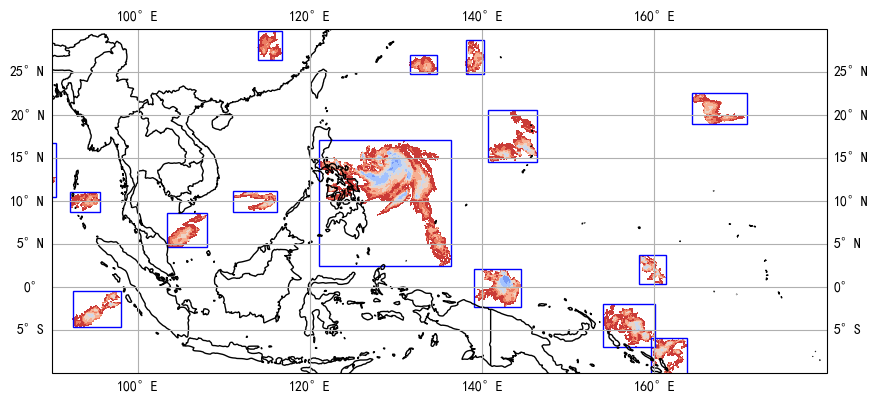

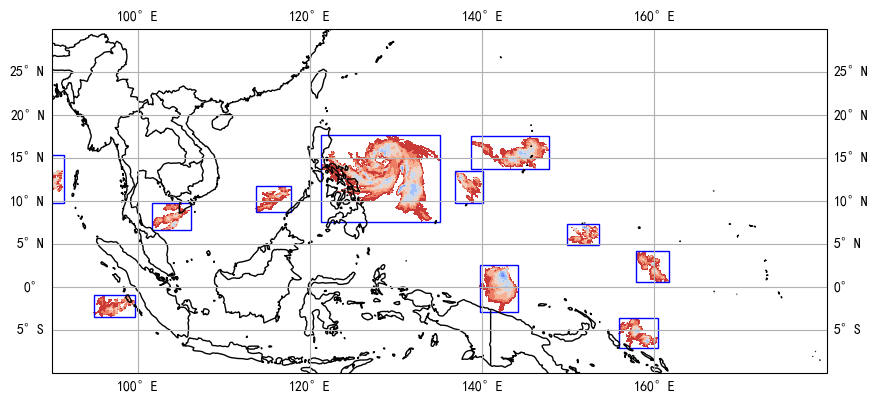

In [17]:
# 第一个时刻
img1  = draw_boximg(lon, lat, criteria1_tbdata, points_list,centroids , criteria_1_mcs_label_id )
img2 = draw_boximg(lon, lat, criteria1_tbdata2, points_list2,centroids2 , criteria_1_mcs_label_id2 )

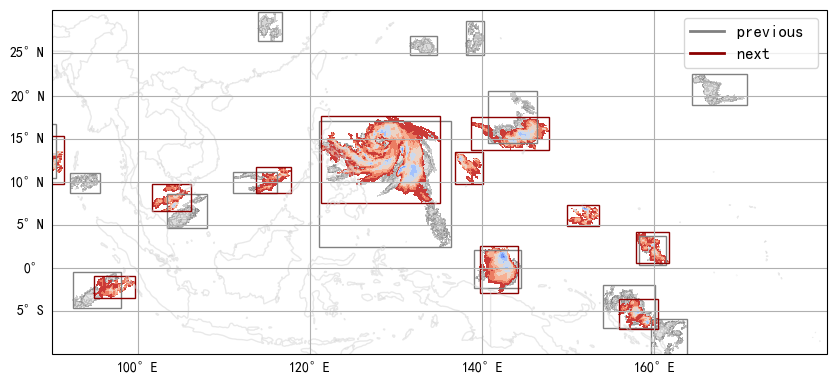

In [18]:
from matplotlib.lines import Line2D
# 设置防止中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 创建图形和投影设置
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
grid = ax.gridlines(draw_labels=True)
grid.top_labels = False
grid.right_labels = False
ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
ax.set_extent([90, 180, -10, 30], crs=ccrs.PlateCarree())


# 第一个时刻的底图
img = ax.contourf(lon,lat , criteria1_tbdata,
              cmap="binary", 
              alpha =  0.2,
            transform=ccrs.PlateCarree())

# 第二个时刻的底图
img2 =  ax.contourf(lon,lat , criteria1_tbdata2,
              cmap="coolwarm",
              alpha =  1,
              transform=ccrs.PlateCarree())

# # 第三个时刻的底图
# img3 = ax.contourf(lon,lat , criteria1_tbdata3,
#                    cmap="coolwarm",
#                    alpha = 0.8 , 
#                    transform=ccrs.PlateCarree())


# current_centroids = centroids[criteria_1_mcs_label_id]


# 第一个时刻的方框
for i, points in enumerate(points_list):
    polygon = Polygon(points, 
                      closed=True, 
                      edgecolor='gray',
                      facecolor='none', 
                      linewidth=1, 
                      transform=ccrs.PlateCarree())
    ax.add_patch(polygon)
    
# 第二个时刻的方框
for i, points in enumerate(points_list2):
    # 第二个时刻的方框
    polygon2 = Polygon(points, 
                      closed=True, 
                      edgecolor='darkred',
                      facecolor='none', 
                      linewidth=1, 
                      transform=ccrs.PlateCarree())
    ax.add_patch(polygon2)



# # 第三个时刻的方框
# # 第二个时刻的方框
# for i, points in enumerate(points_list3):
#     # 第二个时刻的方框
#     polygon2 = Polygon(points, 
#                       closed=True, 
#                       edgecolor='blue',
#                       facecolor='none', 
#                       linewidth=1, 
#                       transform=ccrs.PlateCarree())
#     ax.add_patch(polygon2)
    

# ===== 添加图例 =====
legend_elements = [
    Line2D([0], [0], color='gray', lw=2, linestyle='-',
           label='previous '),

    Line2D([0], [0], color='darkred', lw=2, linestyle='-',
           label='next '),
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=12)



# 
# # 标记处 stats对应的点, 也就是画框的起始点   
# # x_min = current_boxes[:,0][i]
# # y_top = current_boxes[:,1][i]
# # ax.scatter(lon[x_min], lat[y_top],
# #            s=15, 
# #            c='b', 
# #            edgecolors='black', 
# #            linewidth=1,
# #            transform=ccrs.PlateCarree(),
# #            )
# 
# # 画出质心位置
# i_centroid_x_index = current_centroids[i][0]     # 忽略背景
# i_centroid_y_index = current_centroids[i][1]     # 忽略背景 
# ax.scatter(lon[int(i_centroid_x_index)],   # 由于质心不一定为整数， 但是索引要求取整，故用int
#            lat[int(i_centroid_y_index)],
#        s=15, 
#        c='g', 
#        edgecolors='g', 
#        linewidth=1,
#        transform=ccrs.PlateCarree(),
#        )


plt.show()

In [19]:
""" 识别出两个框  """
# def track_boxes(current_boxes, next_boxes, iou_threshold=0.5):
#     """
#     追踪当前帧的框到下一帧，并识别新出现的框和消失的框。
#     思路： 消失的框要根据  current_boxes ， 新出现的框要根据  next_boxes , 识别出了两个框
#     :param current_boxes: list of boxes (x, y, w, h)，当前帧的框
#     :param next_boxes: list of boxes (x, y, w, h)，下一帧的框
#     :param iou_threshold: IoU 阈值，默认为 0.5
#     :return: dict 包含：
#              - 'tracked_boxes': list of (curr_box, matched_next_box)
#              - 'disappeared_boxes': list of curr_box 没有找到匹配的
#              - 'new_boxes': list of next_box 没有被匹配到任何 curr_box
#     """    
#     tracked_boxes = []
#     disappeared_boxes = []
#     used_next_boxes = []  # 记录已被匹配的 next_boxes
# 
#     # 第一步：匹配 current_boxes 到 next_boxes
#     for current_box in current_boxes:
#         best_match = None
#         best_iou = 0
#         for next_box in next_boxes:
#             iou = calculate_overlap_area(current_box, next_box)
#             if iou > best_iou:
#                 best_match = next_box
#                 best_iou = iou
#         if best_iou >= iou_threshold:
#             tracked_boxes.append((current_box, best_match))
#             used_next_boxes.append(best_match)  # 标记为已使用
#         else:
#             disappeared_boxes.append(current_box)
# 
#     # 第二步：找出 new_boxes（未被匹配的 next_boxes）
#     new_boxes = [box for box in next_boxes if box not in used_next_boxes]
# 
#     return {
#         "tracked_boxes": tracked_boxes,
#         "disappeared_boxes": disappeared_boxes,
#         "new_boxes": new_boxes
#     }


' 识别出两个框  '

In [20]:
"""  输入已知的框进行追踪  """  
def track_boxes( all_t_boxes, iou_threshold=0.5):
    """
    追踪当前帧的框到下一帧，并识别新出现的框和消失的框。
    all_t_boxes: list , 每个元素都代表着一个时刻的所有的框
    :param iou_threshold: IoU 阈值，默认为 0.5
    :return: list 
    """   

    init_t = 0     #  表示时刻，  真实的持续时间用 t * 3  , 因为GridSat B1的时间分辨率是 3h   
    total_tracked_ids = 0
    all_trac_framelist = []      # 储存所有时刻的轨迹信息
    used_next_boxes = []  # 记录已被匹配的 next_boxes
    
    # 初始化box, 给其 id ， t 和  box 坐标
    init_t_trac_framelist = []
    for i, i_box in enumerate(all_t_boxes[0]):
        # 给当前图片的框做标记
        boxes_frame = {
                    "total_time": init_t,
                    "track_id ": total_tracked_ids, 
                    "track_boxes": i_box.tolist()  
                                          }
        init_t_trac_framelist.append(boxes_frame)
        total_tracked_ids += 1
    all_trac_framelist.append(init_t_trac_framelist)

    # 从第二个时刻开始追踪
    for t in range(1, len(all_t_boxes)):  
        i_t_trac_framelist =[]       # 记录一个时刻的所有轨迹框 ， 也就是从 第二张 图开始记录  
        # 前后两个时刻的所有的框
        current_boxes =  all_t_boxes[t-1]
        next_boxes = all_t_boxes[t]
        
        # 比较前、后两个时刻的框
        for i, i_curren_box in enumerate(current_boxes):   # 也就是前一时刻的某一个框
            i_current_id = all_trac_framelist[t-1][i]["track_id "]   
            # 判断是否匹配的标准
            best_match_box = None
            best_iou = 0 
            for i_next_box in next_boxes:
                iou = calculate_overlap_area(i_curren_box, i_next_box)
                if iou > best_iou:
                    best_match_box = i_next_box
                    best_iou = iou
            if best_iou >= iou_threshold:  
                # tracked_boxes.append((i_curren_box, best_match_box))
                # 同一片云， 赋予下一个时刻同样的id
                next_boxes_frame = {
                        "total_time": t ,
                        "track_id ": i_current_id, 
                        "track_boxes": best_match_box.tolist()   # 下一个时刻中与前一个时刻最匹配的 框     
                                  }
                i_t_trac_framelist.append(next_boxes_frame)
                
                # next_boxes_frame_list.append(next_boxes_frame)   
                used_next_boxes.append(best_match_box.tolist())  # 标记下一个图片中已使用, 也就是记录同一片云 
            # else:
            #     total_tracked_ids += 1   # 更新id
                # disappeared_boxes.append(i_curren_box)
                # # 未找到与上一个时刻的同一片云，  赋予新的id
                # disappeared_boxes_frame = {
                #         "total_time": t - 1 ,        # 下个时刻没有了，这说明还是处于第0时刻
                #         "track_id ": total_tracked_ids, 
                #         "track_boxes": i_curren_box.tolist() 
                #                   }
                # disappeared_boxes_frame_list.append(disappeared_boxes_frame)
            
        # 赋予后一个时刻中 没有id 的框的信息 ，也就是相较于上一张图片，后一张图片中新出现的框
        new_boxes = []
        for box in next_boxes:
            if box.tolist() not in used_next_boxes:    # 如果不转化为 list， 那么 numpy数组和 列表的比较会报错
                new_boxes.append(box)
                 # 更新 id
                total_tracked_ids += 1                
                new_boxes_frame ={
                     "total_time": t,        # 下个时刻没有了， 说明还是处于第0时刻
                     "track_id ": total_tracked_ids , 
                     "track_boxes": box.tolist()  
                }
                i_t_trac_framelist.append(new_boxes_frame)
        
        # 储存整个时刻的框的信息 
        all_trac_framelist.append(i_t_trac_framelist)

    return all_trac_framelist


In [21]:
def print_organized_tracks(all_trac_framelist, method='id'):
    """
    根据参数 method 展示 MCS 轨迹信息。
    参数:
        all_trac_framelist: track_boxes 返回的结果
        method: 
            - 'id': 按照轨迹 ID 展示（默认）
            - 't': 按照时间帧展示
    """
    if method == 'id':
        # 按照 MCS ID 组织数据
        tracks_by_id = {}  # {track_id: [(time, box)]}            
        for time_step in all_trac_framelist:
            t = time_step[0]["total_time"] if time_step else None
            for item in time_step:
                track_id = item["track_id "]
                time = item["total_time"]
                box = item["track_boxes"]

                if track_id not in tracks_by_id:
                    tracks_by_id[track_id] = []
                # tracks_by_id[track_id].append(box)
                tracks_by_id[track_id].append((time, box))
                
                

        # 打印按 ID 分组的轨迹
        for track_id in sorted(tracks_by_id.keys()):
            # print(tracks_by_id[track_id])  # 按照不同的id， 那出数据
            print(f"MCS ID: {track_id}")
            for time, box in tracks_by_id[track_id]:
                print(f"    Time {time} → {box}")
            print()

    elif method == 't':
        # 按照时间帧组织数据
        tracks_by_t = {}  # {time: [(track_id, box)]}

        for time_step in all_trac_framelist:
            t = time_step[0]["total_time"] if time_step else None
            if t is not None:
                if t not in tracks_by_t:
                    tracks_by_t[t] = []
                for item in time_step:
                    track_id = item["track_id "]
                    box = item["track_boxes"]
                    # tracks_by_t[t].append((track_id, box))  
                    tracks_by_t[t].append(box)  # 拿出 box 的坐标       

        # 打印按 时间帧 分组的轨迹
        for t in sorted(tracks_by_t.keys()):
            print("==="*10)
            # print(tracks_by_t[t])    
            print(f"时刻 t: {t}")
            for track_id, box in tracks_by_t[t]:
                print(f"    ID {track_id} → {box}")
            print()

    else:
        raise ValueError("method 必须是 'id' 或 't'")

In [22]:
# 不同时刻的数据应该由 next 进行连接 
all_t_boxes= [current_boxes,next_boxes , next_boxes3 ]

# 数据跟踪和打印
result = track_boxes( all_t_boxes, iou_threshold=0.5 )   
print_organized_tracks(result)   

MCS ID: 0
    Time 0 → [2544, 22, 93, 79]
    Time 1 → [2514, 10, 200, 222]
    Time 2 → [2561, 11, 172, 217]

MCS ID: 1
    Time 0 → [2455, 46, 112, 76]

MCS ID: 2
    Time 0 → [2443, 101, 141, 137]

MCS ID: 3
    Time 0 → [2009, 173, 151, 99]

MCS ID: 4
    Time 0 → [2296, 200, 115, 46]

MCS ID: 5
    Time 0 → [1782, 232, 126, 103]
    Time 1 → [1799, 202, 187, 140]
    Time 2 → [2207, 149, 251, 51]

MCS ID: 6
    Time 0 → [3094, 254, 65, 59]

MCS ID: 7
    Time 0 → [4852, 709, 59, 63]

MCS ID: 8
    Time 0 → [4771, 757, 87, 72]
    Time 1 → [4798, 755, 65, 51]
    Time 2 → [1851, 244, 98, 91]

MCS ID: 9
    Time 0 → [3892, 791, 80, 60]
    Time 1 → [3927, 807, 69, 37]

MCS ID: 10
    Time 0 → [4558, 824, 78, 62]
    Time 1 → [4567, 815, 64, 79]

MCS ID: 11
    Time 0 → [4832, 862, 44, 48]
    Time 1 → [4827, 865, 55, 51]
    Time 2 → [4811, 747, 40, 49]

MCS ID: 12
    Time 0 → [91, 872, 36, 35]

MCS ID: 13
    Time 0 → [1362, 882, 42, 41]
    Time 1 → [1353, 877, 58, 65]
    Time 2

## 对时间进行筛选

In [58]:
"""  至少存在2 个时刻 """
def choice_t(all_trac_framelist):
    """ 
    all_trac_framelist: 该参数是根据 函数track_boxes 拿到的列表
    time_criteria: [[(t,box的x,y,w,h)], ...]
    """
    # 按照 ID 组织数据 , 也就是不同的框出现的个数
    tracks_by_id = {}  # {track_id: [(time, box)]} 
    time_criteria = []
    for time_step in all_trac_framelist:  # time_step 代表一个时刻的框
        for i_box in time_step:
            track_id = i_box["track_id "]
            t = i_box["total_time"]       # t表示时刻 
            box = i_box["track_boxes"]
            if track_id not in tracks_by_id:
                tracks_by_id[track_id] = []
            tracks_by_id[track_id].append((t, box))   # 将同一个id的框， 存储起来

    # 判断个数， 也就是 每个框存在了多少个时刻
    for track_id in sorted(tracks_by_id.keys()):
        if len(tracks_by_id[track_id]) >= 2:
            # print(tracks_by_id[track_id])
            time_criteria.append(tracks_by_id[track_id])
    print(time_criteria)
    print()

